### My Purpose for Analyzing This Eventlog

I was particularly interested in understanding **Turnaround Time (TAT)**: the time it takes for a case to move from being opened to being closed. The main questions I aimed to explore were:

1. What is the typical Turnaround Time for this process?
2. How can that TAT be broken down across different activities involved in resolving a case? Which activities consume the most time?
3. What features/attributes have an impact on case duration (TAT)?
4. What insights can we uncover by applying **unsupervised clustering** to the completed cases?
5. Can we build a model to predict the **"time remaining until case closure"**, using only the features available from the most recent status update?  

In [1]:
# Import required liberaries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import f_oneway


# clustering liberarie
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Other ML Liberaries
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


pd.set_option('display.max_columns', None)

**Key Functions:** These are the functions I used to simplify some of lines of code during the analysis

In [2]:
# Key Functions

def clean_log(data, CaseID='caseid_column', Activity='activity_column', EndTimeStamp='end_column'):
    
    # create a dictionary to map old column names to new column names
    rename_dict = {CaseID: 'CaseID', Activity: 'Activity', EndTimeStamp: 'EndTimeStamp'}
    
    # use the rename method to rename the columns in the DataFrame
    data = data.rename(columns=rename_dict)

    
    # convert datetime column and set the correct format (dd-mm)
    data['EndTimeStamp'] = pd.to_datetime(data['EndTimeStamp'], dayfirst=True)
    data['opened_at'] = pd.to_datetime(data['opened_at'], dayfirst=True)
    data['closed_at'] = pd.to_datetime(data['closed_at'], dayfirst=True)

    eventlog = data

    return eventlog



def add_event_duration(eventlog):

    # Create a list of unduplicated Case IDs
    case_ids = eventlog['CaseID'].drop_duplicates().tolist()

    # Initialize an empty dataframe
    new_eventlog = pd.DataFrame()

    # Loop to create a Case Log
    for case in case_ids:
        case_activities = eventlog[eventlog['CaseID'] == case]

        # Sort events based on start date & time
        case_activities = case_activities.sort_values(by='EndTimeStamp', ascending=True)

        # add event_duration_days to case_activities
        case_activities['event_duration_days'] = (case_activities['EndTimeStamp'] - case_activities['EndTimeStamp'].shift(1) ).dt.total_seconds() / (60 * 60 * 24)

        # replace the NaN value in first row in event_duration_days with time difference between EndTimeStamp and opened_at
        case_activities.loc[case_activities.index[0], 'event_duration_days']  = (case_activities['EndTimeStamp'].iloc[0] - case_activities['opened_at'].iloc[0]).total_seconds() / (60 * 60 * 24)

        # append case activities to new_eventlog
        new_eventlog = pd.concat([new_eventlog, case_activities])

    return new_eventlog






def generate_CaseAttributes(eventlog):


    # Create a list of unduplicated Case IDs
    case_ids = eventlog['CaseID'].drop_duplicates().tolist()

    # Initialize list to store case logs
    rows = []

    # Loop to create a Case Log
    for case in case_ids:
        case_activities = eventlog[eventlog['CaseID'] == case]

        # Sort events based on start date & time
        case_activities = case_activities.sort_values(by='EndTimeStamp', ascending=True)

        # Get start timestamp in case
        opened_at = case_activities['opened_at'].iloc[0]

        # Get end timestamp in case
        closed_at = case_activities['closed_at'].iloc[0]

        # get case contact_type	location	category	subcategory	priority
        # Get case contact_type
        contact_type = case_activities['contact_type'].iloc[0]
        # Get case location
        location = case_activities['location'].iloc[0]  
        # Get case category
        category = case_activities['category'].iloc[0]
        # Get case subcategory
        subcategory = case_activities['subcategory'].iloc[0]
        # Get case priority
        priority = case_activities['priority'].iloc[0]

        # note if the case is complete or have missing activities (this one ois to address cases that seem to be missing some activities at the begining)
        if case_activities['Activity'].iloc[0] == 'New':
            case_condition = 'Complete'
        else:
            case_condition = 'Incomplete'

        # Write all application journey in one string
        variant = case_activities['Activity'].str.cat(sep='-')

        # Get number of activities per case
        activity_instances = len(case_activities)


        # Sum the durations for each event in a case and put the output in a dictionary 
        event_duration = case_activities.groupby('Activity')['event_duration_days'].sum().reset_index()
        event_duration = event_duration.set_index('Activity').T
        # Add the string "_totalduration" to the end of each column name
        # event_duration = event_duration.add_suffix('__totalduration')  # this will create an issue aggragating activity duration later
        # Convert the event_duration DataFrame to a dictionary
        event_duration_dict = event_duration.iloc[0].to_dict()



        # Create a count of each activity in the case
        activity_counts = case_activities.groupby('Activity').size().reset_index(name='Count')

        # transpose the output 
        activity_counts = activity_counts.set_index('Activity').T
        # Add the string "_count" to the end of each column name
        activity_counts = activity_counts.add_suffix('_count')

        # Convert the activity_counts DataFrame to a dictionary
        activity_counts_dict = activity_counts.iloc[0].to_dict()



        rows.append({
            'CaseID': case,
            'opened_at': opened_at,
            'closed_at': closed_at,
            'Case_Variant': variant,
            'Case_NoOfEvents': activity_instances,
            'Case_Condition': case_condition,
            'contact_type': contact_type,
            'location': location,
            'category': category,
            'subcategory': subcategory,
            'priority': priority,
            ** event_duration_dict,
            ** activity_counts_dict
            })

    # Create DataFrame from rows
    CaseLog = pd.DataFrame(rows)

    # Add case duration column
    CaseLog['Case_Duration_days'] = (CaseLog['closed_at'] - CaseLog['opened_at']).dt.total_seconds() / (60 * 60 * 24)

    # Add CaseStart_week column
    CaseLog['Case_StartWeek'] = CaseLog['opened_at'].dt.isocalendar().week
    # Add CaseStart_month column
    CaseLog['Case_StartMonth'] = CaseLog['opened_at'].dt.month
    # Add CaseStart_year column
    CaseLog['Case_StartYear'] = CaseLog['opened_at'].dt.year
    # add CaseStart_hour column
    CaseLog['Case_StartHour'] = CaseLog['opened_at'].dt.hour
    # add CaseStart_dayof week column
    CaseLog['Case_StartDayOfWeek'] = CaseLog['opened_at'].dt.dayofweek
    


    # rename the output to filtered_case_attributes to keep wording consistent
    filtered_case_attributes = CaseLog

    return filtered_case_attributes




def plot_weekly_case_count(filtered_case_attributes):    
    
    # Keep a smaller copy of case attributes with only case start & end dates
    case_attribute_short = filtered_case_attributes[['CaseID', 'opened_at', 'closed_at']].copy()

    # Extract ISO calendar year, week, and month for end date
    # iso_end = case_attribute_short["closed_at"].dt.isocalendar()
    # case_attribute_short["CaseEnd_Month"] = case_attribute_short["closed_at"].dt.month
    # case_attribute_short["CaseEnd_Week"] = iso_end.week
    # case_attribute_short["CaseEnd_Year"] = iso_end.year
    # case_attribute_short['CaseEnd_Year_Week'] = iso_end.year.astype(str) + '-W' + iso_end.week.astype(str).str.zfill(2)
    case_attribute_short['CaseEnd_WeekStart'] = case_attribute_short['closed_at'].dt.to_period('W-MON').dt.start_time


    # Extract ISO calendar year, week, and month for start date
    # iso_start = case_attribute_short["opened_at"].dt.isocalendar()
    # case_attribute_short["CaseStart_Month"] = case_attribute_short["opened_at"].dt.month
    # case_attribute_short["CaseStart_Week"] = iso_start.week
    # case_attribute_short["CaseStart_Year"] = iso_start.year
    # case_attribute_short['CaseStart_Year_Week'] = iso_start.year.astype(str) + '-W' + iso_start.week.astype(str).str.zfill(2)
    case_attribute_short['CaseStart_WeekStart'] = case_attribute_short['opened_at'].dt.to_period('W-MON').dt.start_time


    # Step 1: Get weekly counts for opened and closed cases
    opened_cases = case_attribute_short['CaseStart_WeekStart'].value_counts().sort_index()
    closed_cases = case_attribute_short['CaseEnd_WeekStart'].value_counts().sort_index()

    # Step 2: Combine into a DataFrame
    weekly_data = pd.DataFrame({
        'Opened': opened_cases,
        'Closed': closed_cases
    }).fillna(0).sort_index()

    # Step 3: Plot as grouped bar chart
    plt.figure(figsize=(15, 6))

    # Set positions and width
    bar_width = 0.4
    weeks = weekly_data.index
    x = np.arange(len(weeks)) * 1.5  # Add spacing between week groups

    plt.bar([i - bar_width/2 for i in x], weekly_data['Opened'], width=bar_width, label='Cases Opened', color='blue', alpha=0.8)
    plt.bar([i + bar_width/2 for i in x], weekly_data['Closed'], width=bar_width, label='Cases Closed', color='green', alpha=0.8)

    # Enhancements
    plt.title('Number of Cases Opened and Closed Per Week', fontsize=16)
    plt.xlabel('Week Start', fontsize=12)
    plt.ylabel('Number of Cases', fontsize=12)
    plt.xticks(ticks=x, labels=[week.strftime('%Y-%m-%d') for week in weeks], rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend()

    plt.tight_layout()
    plt.show()







def plot_dotted_chart(eventlog):

    # # Set the start and end of September 2016
    # start_date = pd.to_datetime('2016-02-29')
    # end_date = pd.to_datetime('2016-09-20')

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 12))
    sns.scatterplot(
        x=eventlog['EndTimeStamp'],
        y=eventlog['CaseID'],
        hue=eventlog['Activity'],
        ax=ax,
        edgecolor='none',  # Remove white outlines
        linewidth=0,
        s=15  # Size of the dots from 10 - 100
        )

    # # Limit x-axis
    # ax.set_xlim([start_date, end_date])

    # Set weekly ticks
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Every week
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format dates nicely

    ax.tick_params(axis='y', which='both', left=False, labelleft=False) # remove y-ticks CaseIDs would clutter the diagram


    # Improve readability
    plt.xticks(rotation=90)
    plt.title('Dotted chart')
    plt.show()



def plot_weekly_tat(filtered_case_attributes):    
    
    # Keep a smaller copy of case attributes with only case start & end dates
    case_attribute_short = filtered_case_attributes[['CaseID', 'opened_at', 'closed_at', 'Case_Duration_days']].copy()

    # Extract ISO calendar year, week, and month for end date
    # iso_end = case_attribute_short["closed_at"].dt.isocalendar()
    # case_attribute_short["CaseEnd_Month"] = case_attribute_short["closed_at"].dt.month
    # case_attribute_short["CaseEnd_Week"] = iso_end.week
    # case_attribute_short["CaseEnd_Year"] = iso_end.year
    # case_attribute_short['CaseEnd_Year_Week'] = iso_end.year.astype(str) + '-W' + iso_end.week.astype(str).str.zfill(2)
    case_attribute_short['CaseEnd_WeekStart'] = case_attribute_short['closed_at'].dt.to_period('W-MON').dt.start_time


    # Extract ISO calendar year, week, and month for start date
    # iso_start = case_attribute_short["opened_at"].dt.isocalendar()
    # case_attribute_short["CaseStart_Month"] = case_attribute_short["opened_at"].dt.month
    # case_attribute_short["CaseStart_Week"] = iso_start.week
    # case_attribute_short["CaseStart_Year"] = iso_start.year
    # case_attribute_short['CaseStart_Year_Week'] = iso_start.year.astype(str) + '-W' + iso_start.week.astype(str).str.zfill(2)
    # case_attribute_short['CaseStart_WeekStart'] = case_attribute_short['opened_at'].dt.to_period('W-MON').dt.start_time


    # Aggregare weekly TAT in a table
    weekly_tat = case_attribute_short.groupby('CaseEnd_WeekStart')['Case_Duration_days'].agg(['mean', 'median', 'count']).reset_index()

    # Create a chart
    # Bar plot for mean and median
    width = 0.35
    x = range(len(weekly_tat))

    # Set up the figure and axes
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax1.bar([i - width/2 for i in x], weekly_tat['mean'], width=width, label='Mean TAT', color='skyblue')
    ax1.bar([i + width/2 for i in x], weekly_tat['median'], width=width, label='Median TAT', color='orange')
    ax1.set_ylabel('Turn Around Time (days)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(weekly_tat['CaseEnd_WeekStart'].dt.strftime('%Y-%m-%d'), rotation=90)

    # Secondary axis for count
    ax2 = ax1.twinx()
    ax2.plot(x, weekly_tat['count'], label='Volume', color='green', linestyle='dotted', marker='o')
    ax2.set_ylabel('Number of cases closed')

    # Ensure secondary y-axis starts at zero
    ax2.set_ylim(bottom=0)

    # Legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Title and layout
    plt.title('Weekly performance of Turn Around Time (TAT) & Volume')
    plt.tight_layout()
    plt.show()







def plot_category_boxplot(filtered_case_attributes, target = 'Case_Duration_days',attribute='subcategory', top=5):

    """"
    This function sort the categories in a certain attribute by volume then present them 
    in boxplots in the order of Median TAT

    """


    sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

    # Step 1: Get top categories
    top_categories = filtered_case_attributes[attribute].value_counts().nlargest(top).index

    # Step 2: Filter data
    filtered_data = filtered_case_attributes[filtered_case_attributes[attribute].isin(top_categories)]

    # Step 3: Calculate medians and sort
    median_order = (
        filtered_data.groupby(attribute)[target]
        .median()
        .sort_values()
        .index
    )

    plt.figure(figsize=(14, 7))

    ax = sns.boxplot(
        data=filtered_data,
        x=attribute,
        y=target,
        order=median_order,
        showfliers=False,
        width=0.6
    )

    sns.stripplot(
        data=filtered_data,
        x=attribute,
        y=target,
        order=median_order,
        color='gray',
        size=3,
        jitter=True,
        alpha=0.3
    )

    # Annotate median values
    medians = filtered_data.groupby(attribute)[target].median()
    for tick, label in enumerate(median_order):
        median_val = medians[label]
        ax.text(
            tick, median_val, f'{median_val:.1f}',
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='semibold'
        )


    ax.set_title(f'{target} Distribution by {attribute} (Top {top})', fontsize=16, weight='bold')
    ax.set_xlabel(attribute, fontsize=12)
    ax.set_ylabel(target, fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    # print the table of means & volums
    grouped = filtered_data.groupby(attribute)[target].agg(['median','mean', 'count']).reset_index()
    grouped.columns = [attribute, f"Median {target}","Mean" ,"Count"]
    grouped = grouped.sort_values(by=f"Median {target}", ascending=True).reset_index(drop= True)  # Use ascending=True for lowest first

    print(grouped.to_string())


    print("_______________________________")

    # Get the groups
    groups = [group[target].values for name, group in filtered_data.groupby(attribute)]

    # Perform one-way ANOVA
    f_stat, p_value = f_oneway(*groups)

    print("F-statistic:", f_stat.round(4))
    print("p-value:", p_value.round(4))




def plot_case_timeline(filtered_case_attributes, color_by=None):
    """
    Plot case timelines with optional coloring based on the categories on one of the columns.

    Parameters:
        filtered_case_attributes (pd.DataFrame): DataFrame with at least ['CaseID', 'opened_at', 'closed_at'] columns.
        color_by (str): Optional. Name of the column to use for coloring groups.
    """

    plt.style.use('default')  # Ensures consistent look
    plt.clf()  # Clear any existing figure in interactive environments
    
    # select only relevant columns
    columns = ['CaseID', 'opened_at', 'closed_at']
    if color_by is not None:
        columns.append(color_by)
    case_timeline = filtered_case_attributes[columns].copy()

    # Convert 'opened_at' and 'closed_at' to datetime and remove the time section
    case_timeline['opened_at'] = pd.to_datetime(case_timeline['opened_at']).dt.date 
    case_timeline['closed_at'] = pd.to_datetime(case_timeline['closed_at']).dt.date
    # Calculate durations
    case_timeline['duration'] = case_timeline['closed_at'] - case_timeline['opened_at']

    # sort cases to improve visualisation
    case_timeline.sort_values(by='opened_at', inplace=True, ascending=False)
    

    fig, ax = plt.subplots(figsize=(20, 12))

    # Assign colors if group_col is provided
    if color_by and color_by in case_timeline.columns:
        groups = case_timeline[color_by].unique()
        color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        group_colors = {group: color_cycle[i % len(color_cycle)] for i, group in enumerate(groups)}
        use_group_color = True
    else:
        use_group_color = False

    # Plot each case as a horizontal bar
    for i, row in case_timeline.iterrows():
        color = group_colors[row[color_by]] if use_group_color else None
        ax.barh(
            row['CaseID'],
            row['duration'].days,
            left=row['opened_at'],
            height=1,
            color=color
        )

    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    plt.xticks(rotation=90)

    # Remove y-axis clutter
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)

    # Labels and title
    plt.xlabel('Date')
    plt.ylabel('Case ID')
    plt.title('Cases over timeline')

    # Add legend if groups are used
    if use_group_color:
        legend_handles = [
            plt.Line2D([0], [0], color=group_colors[group], lw=4, label=group)
            for group in groups
        ]
        ax.legend(handles=legend_handles, title=color_by)

    plt.tight_layout()
    plt.show()


def model_train_and_evaluate(model, X_train, y_train, X_test, y_test):
    """
    Train the model and evaluate its performance on the test set.
    """

    # Determine categorical and numerical columns for encoding
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X_train.select_dtypes(include=['number']).columns.tolist()

    # Set up the pipeline for encoding 
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
            ("num", StandardScaler(), numerical_cols)
        ]
    )

    # Set-up the training, and testing pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Print results
    print(f' Model name & parameters: {model}')
    print('______________________________________')
    print(f'No of training cases: {len(X_train)}')
    print(f'No of testing cases: {len(X_test)}')

    print("\nPerformance Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Test on training set to check for over-fitting
    y_train_pred = pipeline.predict(X_train)

    # Calculate performance metrics for training set
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_train_pred)
    # Print results for training set
    print("\nTraining Set Performance:")
    print(f"Mean Absolute Error (MAE): {mae_train:.4f}")
    print(f"Mean Squared Error (MSE): {mse_train:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_train:.4f}")
    print(f"R² Score: {r2_train:.4f}")


In [3]:
# upload the eventlog dataset
eventlog = pd.read_csv('incident_event_log.csv')

## 1. Understanding the Eventlog and Data Preparation


#### Dataset Information

This dataset is publicly available: https://archive.ics.uci.edu/dataset/498/incident+management+process+enriched+event+log


This is an event log of an incident management process extracted from data gathered from the audit system of an instance of the ServiceNow™ platform used by an IT company. The event log is enriched with data loaded from a relational database underlying a corresponding process-aware information system. Information was anonymized for privacy.

- **Number of instances:** 141,712 events (24,918 incidents)  
- **Number of attributes:** 36 attributes (1 case identifier, 1 state identifier, 32 descriptive attributes, 2 dependent variables)

The attribute `closed_at` is used to determine the dependent variable for the time completion prediction task. The attribute `resolved_at` is highly correlated with `closed_at`.

In this event log, some rows may have the same values (they are equal), since not all attributes involved in the real-world process are present in the log. Attributes used to record textual information are not included. Missing values should be considered as “unknown information.”


**number**: Incident identifier (24,918 different values).  
**incident_state**: Eight levels controlling the incident management process transitions from opening until closing the case.  
**active**: Boolean attribute that shows whether the record is active or closed/canceled.  
**reassignment_count**: Number of times the incident has had the group or the support analysts changed.  
**reopen_count**: Number of times the incident resolution was rejected by the caller.  
**sys_mod_count**: Number of incident updates until that moment.  
**made_sla**: Boolean attribute that shows whether the incident exceeded the target SLA.  
**caller_id**: Identifier of the user affected.  
**opened_by**: Identifier of the user who reported the incident.  
**opened_at**: Incident user opening date and time.  
**sys_created_by**: Identifier of the user who registered the incident.  
**sys_created_at**: Incident system creation date and time.  
**sys_updated_by**: Identifier of the user who updated the incident and generated the current log record.  
**sys_updated_at**: Incident system update date and time.  
**contact_type**: Categorical attribute that shows by what means the incident was reported.  
**location**: Identifier of the location of the place affected.  
**category**: First-level description of the affected service.  
**subcategory**: Second-level description of the affected service (related to the first-level description, i.e., to *category*).  
**u_symptom**: Description of the user's perception about service availability.  
**cmdb_ci**: (Configuration Item) Identifier used to report the affected item (not mandatory).  
**impact**: Description of the impact caused by the incident (values: 1–High, 2–Medium, 3–Low).  
**urgency**: Description of the urgency informed by the user for the incident resolution (values: 1–High, 2–Medium, 3–Low).  
**priority**: Calculated by the system based on *impact* and *urgency*.  
**assignment_group**: Identifier of the support group in charge of the incident.  
**assigned_to**: Identifier of the user in charge of the incident.  
**knowledge**: Boolean attribute that shows whether a knowledge base document was used to resolve the incident.  
**u_priority_confirmation**: Boolean attribute that shows whether the *priority* field has been double-checked.  
**notify**: Categorical attribute that shows whether notifications were generated for the incident.  
**problem_id**: Identifier of the problem associated with the incident.  
**rfc**: (Request for Change) Identifier of the change request associated with the incident.  
**vendor**: Identifier of the vendor in charge of the incident.  
**caused_by**: Identifier of the RFC responsible for the incident.  
**close_code**: Identifier of the resolution of the incident.  
**resolved_by**: Identifier of the user who resolved the incident.  
**resolved_at**: Incident user resolution date and time (dependent variable).  
**closed_at**: Incident user close date and time (dependent variable).


#### A. Dataset Discovery and Understanding

The purpose of this step was to get familiar with the features in the event log, data types, meanings, and the common categories within each one. I reflected on both the feature descriptions and how the data behaves to better understand what each feature actually represents in the context of the real business process.

*Note: I didn’t include the code for this stage, since it was pretty basic. The real value came from exploring and learning about the process and the dataset itself. The insights gained here were used in the next section to filter out irrelevant features.*


#### B. Basic Clean up
In this section, I'm removing unrelevant features, fixing basic missing & bad data (mostly be removing from dataset)
______________________________________________

In [4]:
# Remove all columns determined to be unnecessary

# List the columns to remove
columns_to_remove = ["caller_id", "reopen_count", "sys_created_by",
    "sys_created_at", "u_symptom", "cmdb_ci", "impact", "urgency",
    "assignment_group", "assigned_to", "u_priority_confirmation",
    "notify", "problem_id", "rfc", "vendor", "caused_by", "closed_code",
    "resolved_by", "resolved_at", "reassignment_count", "knowledge",
    "made_sla"
]

# remove the columns from the dataset
eventlog = eventlog.drop(columns=columns_to_remove)

In [5]:
# Removing all cases/incidents with the stange state "-100"
# Identify cases with the state "-100"
cases_with_wrong_activities = eventlog[eventlog['incident_state'] == '-100']['number'].unique().tolist()

# removing the tow cases with state "-100" from dataset
eventlog = eventlog[~eventlog['number'].isin(cases_with_wrong_activities)]

In [6]:
# remove all cases with contact type "IVR" as they are they were the only cases with zero turn around time - which is a problem worth investigating
eventlog = eventlog[eventlog['contact_type'] != 'IVR']

#### C. Detailed Filtering

In this section, I went through a few critical steps that had a big impact on the rest of the analysis:

- Renamed and defined the column names and data types to make data processing smoother.
- Generated a **Case Attributes** dataset based on the provided event log.
- Kept only complete, end-to-end cases.
- Filtered out weird cases and outliers. This was done iteratively as I uncovered more insights during the analysis.
- Saved a copy of both the filtered **event log** and **case attributes** datasets to help jump-start the rest of the code without having to repeat this section.

##### Key Learnings

- There was an anomaly around **24/03/2016** — cases were piling up and then all closed on a single day. It made more sense to remove this chunk entirely.
- The best way to filter the event log while keeping things consistent for machine learning was by using the **case start date** (e.g., filtering for cases that started between date X and date Y).
- Since case duration (TAT) follows an **exponential distribution**, there’s always a long-tail issue. To tackle this, I introduced the idea of **"Aged Cases"**, this helped filter out extreme outliers, but it also turned out to be useful from a business perspective to better understand why some cases take such a long time to resolve.


In [7]:
# rename the eventlog for clarity and use datetime format
eventlog = clean_log(eventlog, CaseID='number', Activity='incident_state', EndTimeStamp='sys_updated_at')

# Enrich the eventlog with event duration
eventlog = add_event_duration(eventlog)

In [8]:
# Aggregate the eventlog to get the case attributes
case_attributes = generate_CaseAttributes(eventlog)

In [9]:
# before we do anything let's filter out incomplete cases
case_attributes = case_attributes[case_attributes['Case_Condition'] == 'Complete']

In [10]:
## Adding this filter here to improve computational performance
# Keep only cases between dates in the middle of the log where the performance is stable with minimal outliers avoiding some wierd cases at the beginning and end of the log
start_date = '2016-03-20'
end_date = '2016-06-05'

# this approach to fitering will make the start and end of eventlog behave similarly
filtered_case_attributes = case_attributes[(case_attributes['opened_at'] >= start_date) & (case_attributes['opened_at'] <= end_date)].copy()

In [11]:
# set aged_cases_limit in days: the meain purpose is to filter outliers, benefits to analysis is to help separate aged cases and analyse them separatlely and track progress, 
# to make the mean TAT more meaningful getting rid of outliers, and to help ease the variation when aged cases are closed in groves
aged_cases_limit = 45

# no of aged cases in the dataset
no_of_aged_cases = len(filtered_case_attributes[filtered_case_attributes['Case_Duration_days']>=aged_cases_limit])
print(f'Number of aged cases (TAT >= {aged_cases_limit} days): {no_of_aged_cases}')

# filter aged cases out - to avoid the outliers issue for now
filtered_case_attributes = filtered_case_attributes[filtered_case_attributes['Case_Duration_days']<aged_cases_limit]

Number of aged cases (TAT >= 45 days): 448


In [12]:
# filter eventlog based on cases from filtered_case_attributes
filtered_eventlog = eventlog[eventlog['CaseID'].isin(filtered_case_attributes['CaseID'])]

In [13]:
# Export case attributes table to avoid re-running the code
filtered_case_attributes.to_csv('filtered_case_attributes.csv', index=False)

# Export the cleaned dataset to be used for next steps
filtered_eventlog.to_csv('filtered_eventlog.csv', index=False)

## 2. Eventlog Exploration and Basic Analysis

**General Understanding of the cases in our eventlog** in the next few graphs, we can form a general understanding on the composition of cases in our eventlog and how they are distributed over the eventlog timeline with special attention to Turnaround Time

<Figure size 640x480 with 0 Axes>

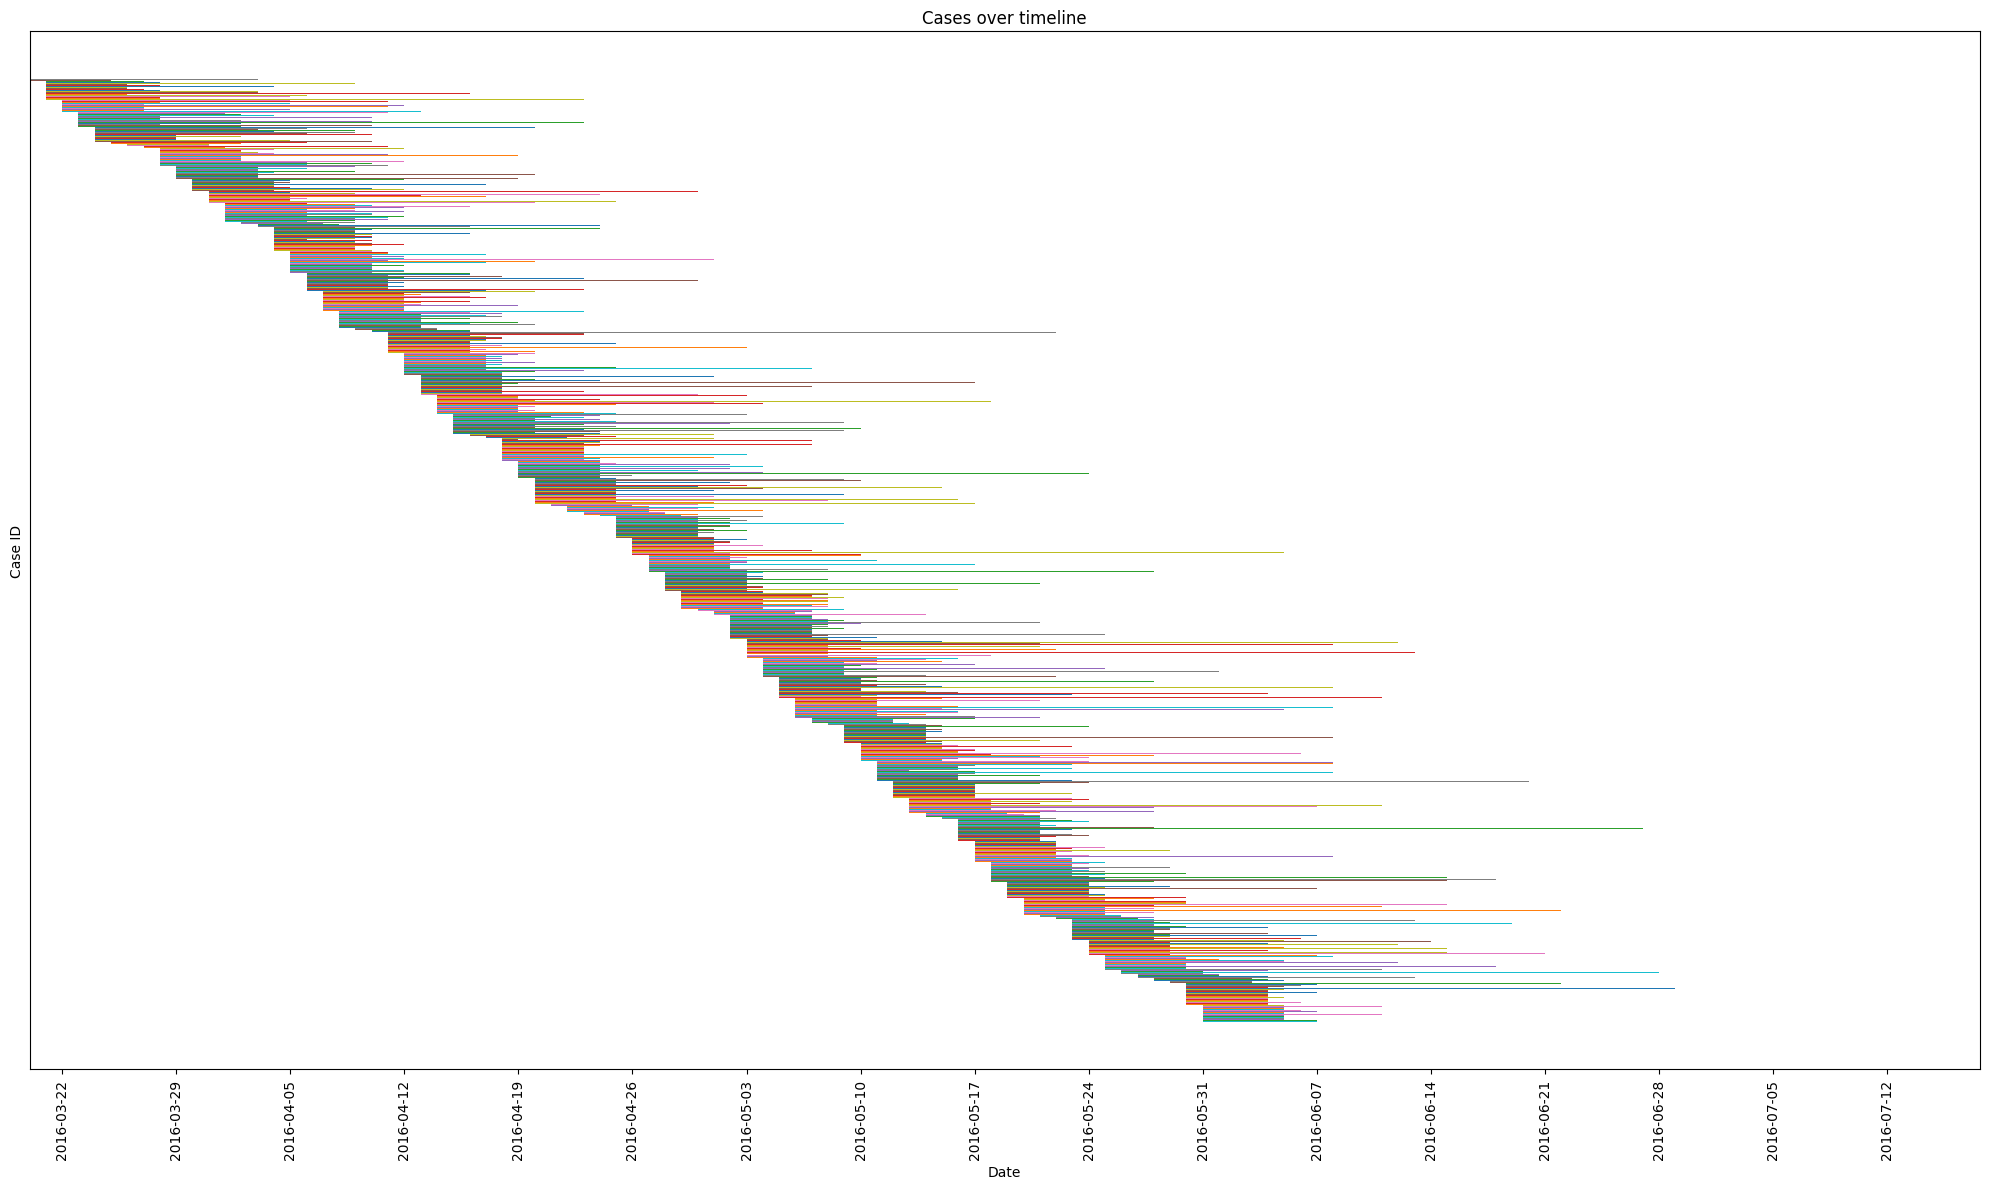

In [14]:
# This graph is  like a Gantt chart showing the timeline of all cases in the eventlog
plot_case_timeline(filtered_case_attributes, color_by=None)

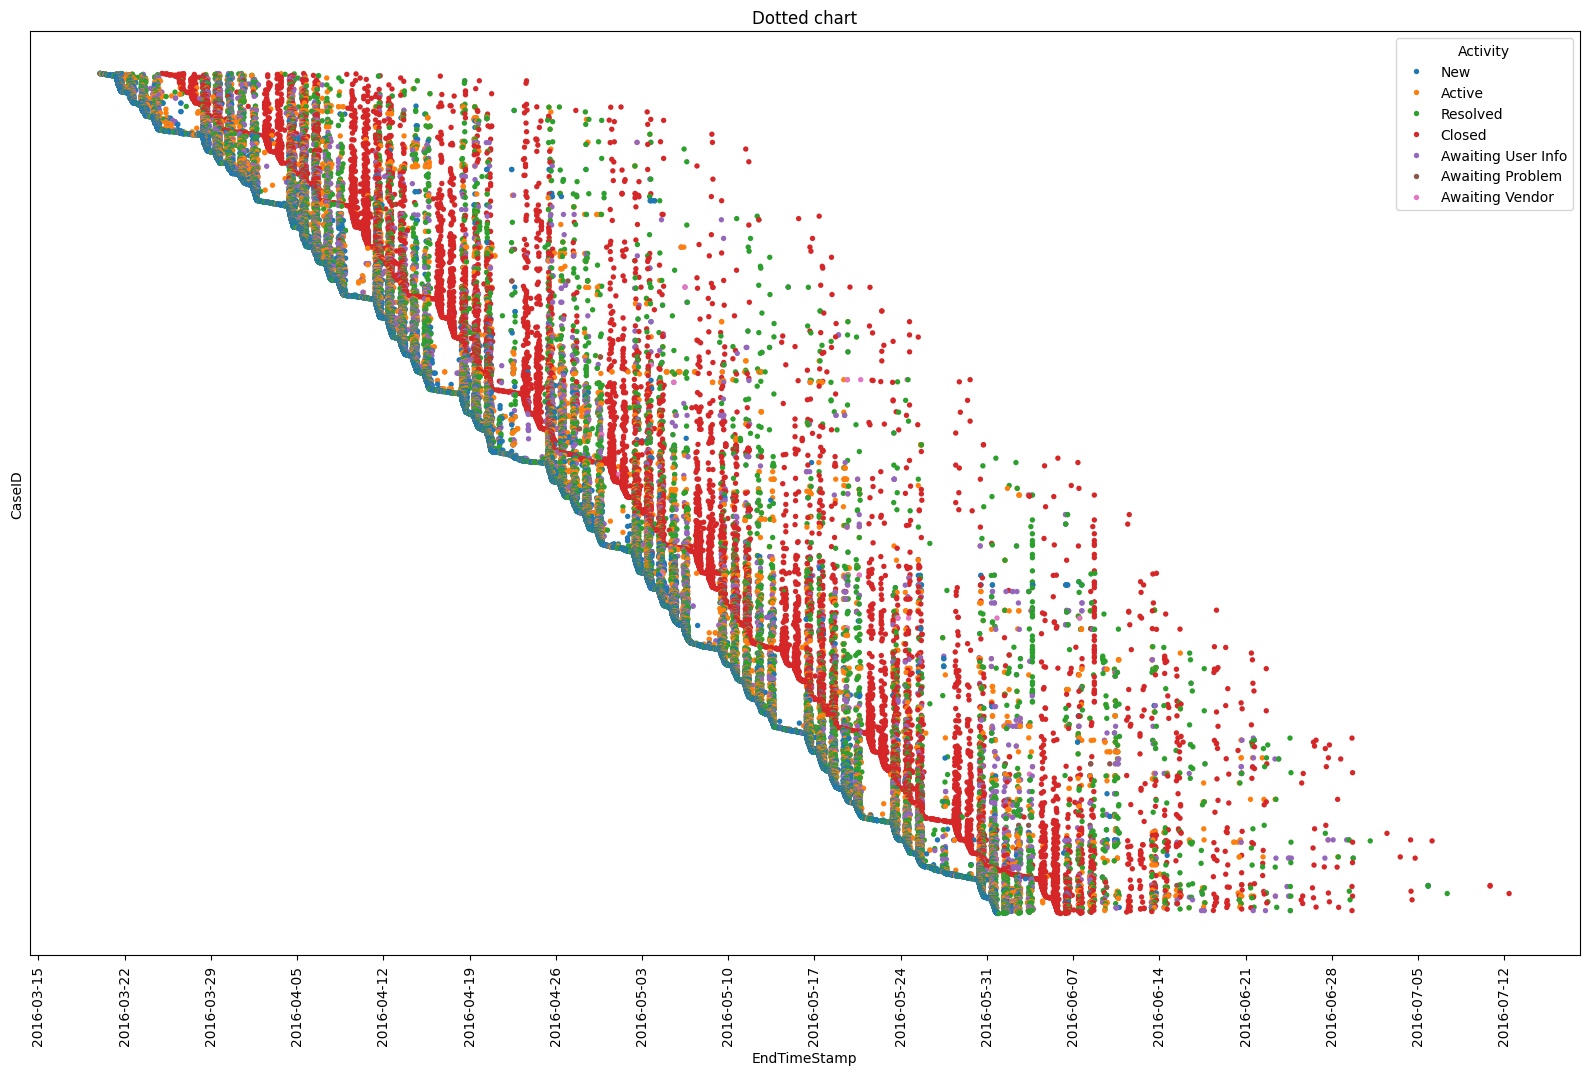

In [15]:
# This graph build on the previous one but instead of showing the case as a bar it shows every Activity as a dot on the timeline
plot_dotted_chart(filtered_eventlog)

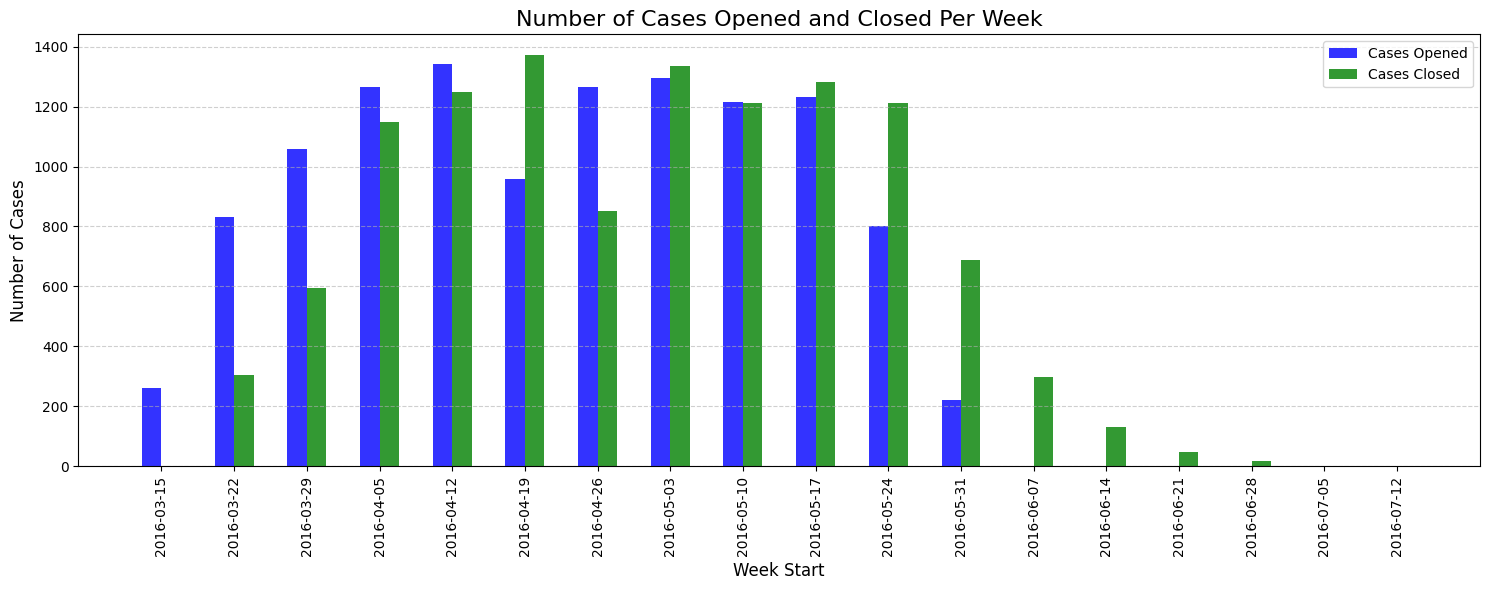

In [16]:
# This graph shows the volume of cases opened and number of cases closed per week i.e. (Volume in and Volume out)
# Note here: depneding on the way you cut the eventlog, there's usually a ramp up and down of volume at the beginning and end of the log
# you need to make sure for some measurements to be taken in the middle of the log where the performance is stable.
plot_weekly_case_count(filtered_case_attributes)

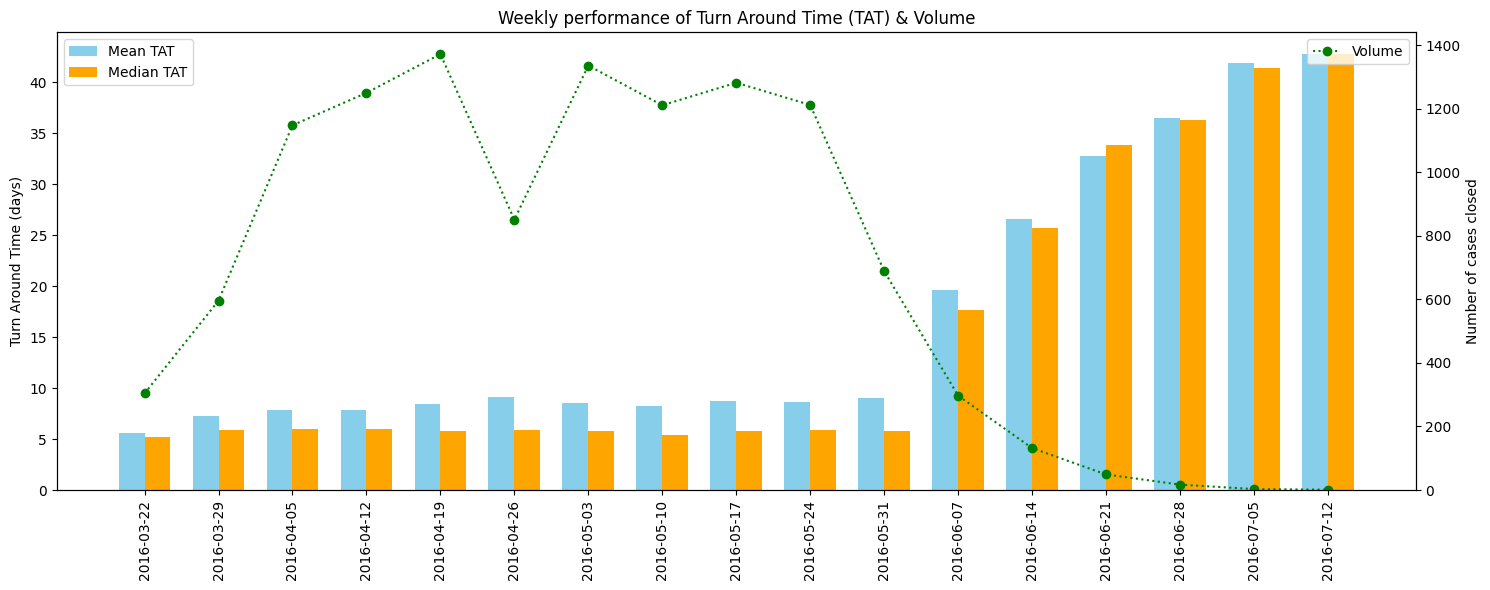

In [17]:
# This graph shows the volume of cases closed per week and the mean and median Turnaround Time (TAT) for theses closed cases
plot_weekly_tat(filtered_case_attributes)

**Answer the first two questions on Turnaround Time**
1. What is the typical Turnaround Time for this process?  
Average Turn around time is ~ 9 days, keeping in mind that the median is ~ 6 days  
  
*Learning: because the distribution is exponential, the mean is significant;y higher than the median even after removing outliers "Aged Cases" - I found the mean more useful in that context as it's more senstive to improvement/decline of process TAT performance but you need a mechanism to remove outliers, otherwise, the mean will be more volatile and less useful when you have extreme outliers. (note: 75th or 80th percentile can be useful if you need to keep the outliers in the dataset)*

2. How can that TAT be broken down across different activities involved in resolving a case? Which activities consume the most time?  

| Status              | Avg Activity Duration (days) |
|---------------------|------------------------------:|
| Closed              |                        5.01   |
| Awaiting Vendor     |                        3.92   |
| Awaiting User Info  |                        3.26   |
| Awaiting Problem    |                        2.80   |
| Active              |                        2.40   |
| Resolved            |                        1.33   |
| New                 |                        0.67   |



In [18]:
print (f"Number of complete cases is: {len(filtered_case_attributes)}")
print (f"Mean case duration in days is: {filtered_case_attributes['Case_Duration_days'].mean().round(1)}")  
print (f"Standard deviation of case duration in days is: {filtered_case_attributes['Case_Duration_days'].std().round(1)}")
print (f"Median case duration in days is: {filtered_case_attributes['Case_Duration_days'].median().round(1)}")
print (f"Max case duration in days is: {filtered_case_attributes['Case_Duration_days'].max().round(1)}")
print (f"Min case duration in days is: {filtered_case_attributes['Case_Duration_days'].min().round(3)}")
print (f'Cases time frame is from ({filtered_case_attributes["opened_at"].min()}) to ({filtered_case_attributes["closed_at"].max()})')

Number of complete cases is: 11750
Mean case duration in days is: 8.9
Standard deviation of case duration in days is: 6.6
Median case duration in days is: 5.9
Max case duration in days is: 44.2
Min case duration in days is: 0.006
Cases time frame is from (2016-03-20 00:17:00) to (2016-07-12 09:00:00)


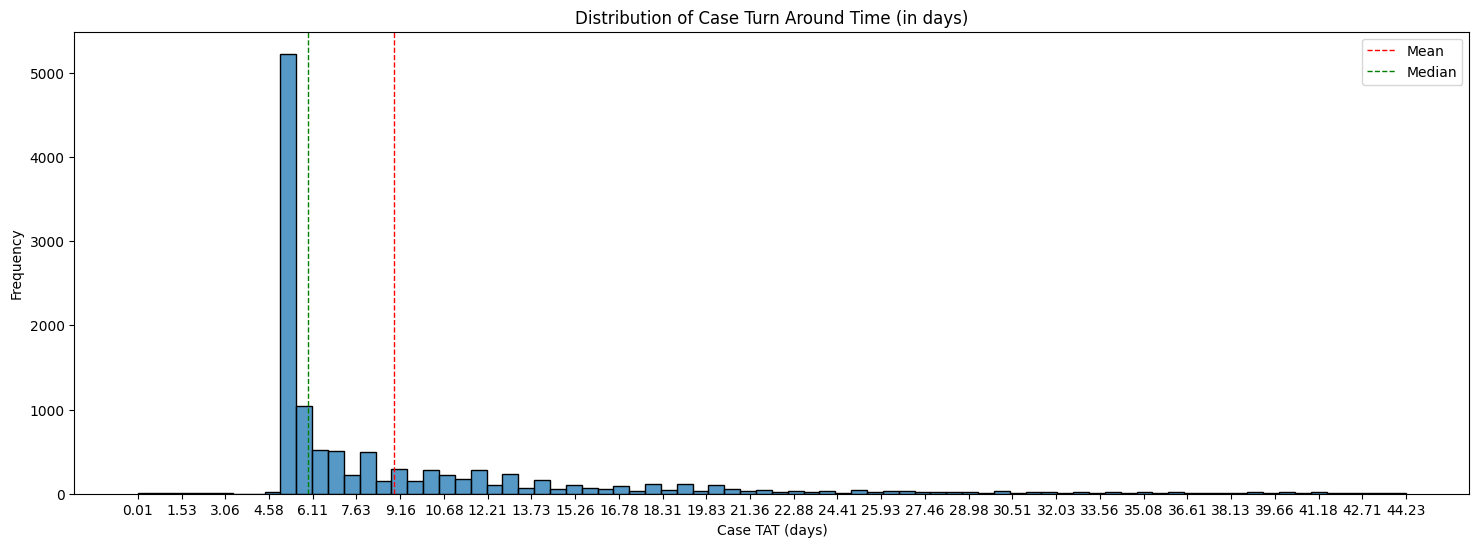

In [19]:
# hostogram of case duration
plt.figure(figsize=(18, 6))
sns.histplot(filtered_case_attributes['Case_Duration_days'], bins=80, )
plt.title('Distribution of Case Turn Around Time (in days)')
plt.xlabel('Case TAT (days)')
plt.ylabel('Frequency') 
plt.axvline(filtered_case_attributes['Case_Duration_days'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(filtered_case_attributes['Case_Duration_days'].median(), color='green', linestyle='dashed', linewidth=1, label='Median')


# Generate and set more x-ticks
min_val = filtered_case_attributes['Case_Duration_days'].min()
max_val = filtered_case_attributes['Case_Duration_days'].max()
xticks = np.linspace(min_val, max_val, num=30)  # increase num for more ticks
plt.xticks(xticks)

# Optional: show legend and plot
plt.legend()
plt.show()

In [20]:
# filter the case attributes on the list of activities from eventlog
activities = filtered_case_attributes[eventlog['Activity'].drop_duplicates().tolist()]

means = activities.mean()
medians = activities.median()
percent_non_empty = activities.notna().mean() * 100  # as percentage
activities_summary = pd.DataFrame({
    'Avg Activity Duration_days': means,
    'Median Activity Duration_days': medians,
    'Percent of cases processed': round(percent_non_empty,2 )
})

activities_summary = activities_summary.sort_values(by='Percent of cases processed', ascending=False)

activities_summary

,Avg Activity Duration_days,Median Activity Duration_days,Percent of cases processed
New,0.671053,0.005556,100.00
Closed,5.005427,5.019444,100.00
Resolved,1.331299,0.016667,99.99
Active,2.397048,0.330556,48.15
Awaiting User Info,3.258617,1.031944,22.69
Awaiting Problem,2.801557,0.245833,0.88
Awaiting Vendor,3.920561,2.914583,0.43
Awaiting Evidence,NaN,NaN,0.00


**Answer the third question** 
3. What features/attributes have an impact on case duration (TAT)?  
We know that the following features have a significant impact on the case duration (TAT)
- The case sequence of steps (variant)
- Case location
- Case category & Subcategory
- case priority - but surprisingly high priority cases took more time than lower priority ones!

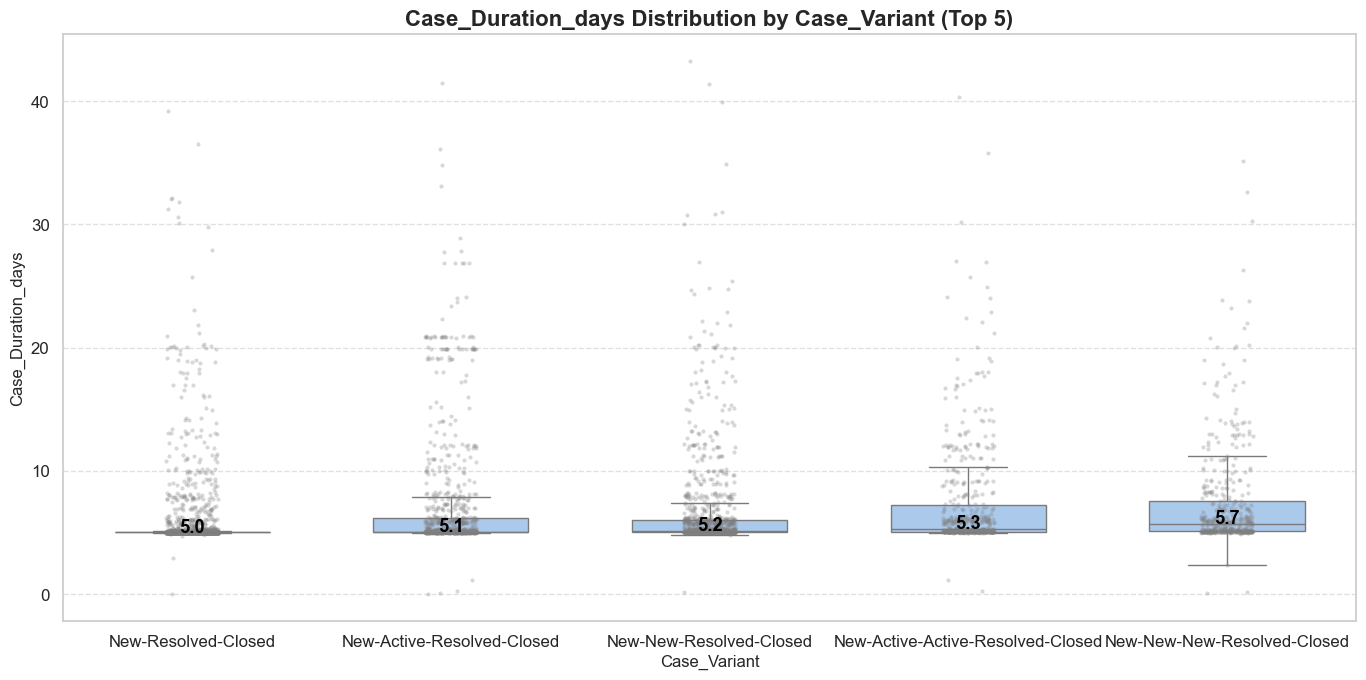

                        Case_Variant  Median Case_Duration_days      Mean  Count
0                New-Resolved-Closed                   5.035417  5.632777   2651
1         New-Active-Resolved-Closed                   5.098611  7.123284    954
2            New-New-Resolved-Closed                   5.159375  6.684433   1132
3  New-Active-Active-Resolved-Closed                   5.300694  7.358304    521
4        New-New-New-Resolved-Closed                   5.699306  7.383678    475
_______________________________
F-statistic: 56.8601
p-value: 0.0


In [21]:
# Compare top case variants by TAT and check for statistical Significance
plot_category_boxplot(filtered_case_attributes, target = 'Case_Duration_days',attribute='Case_Variant', top=5)

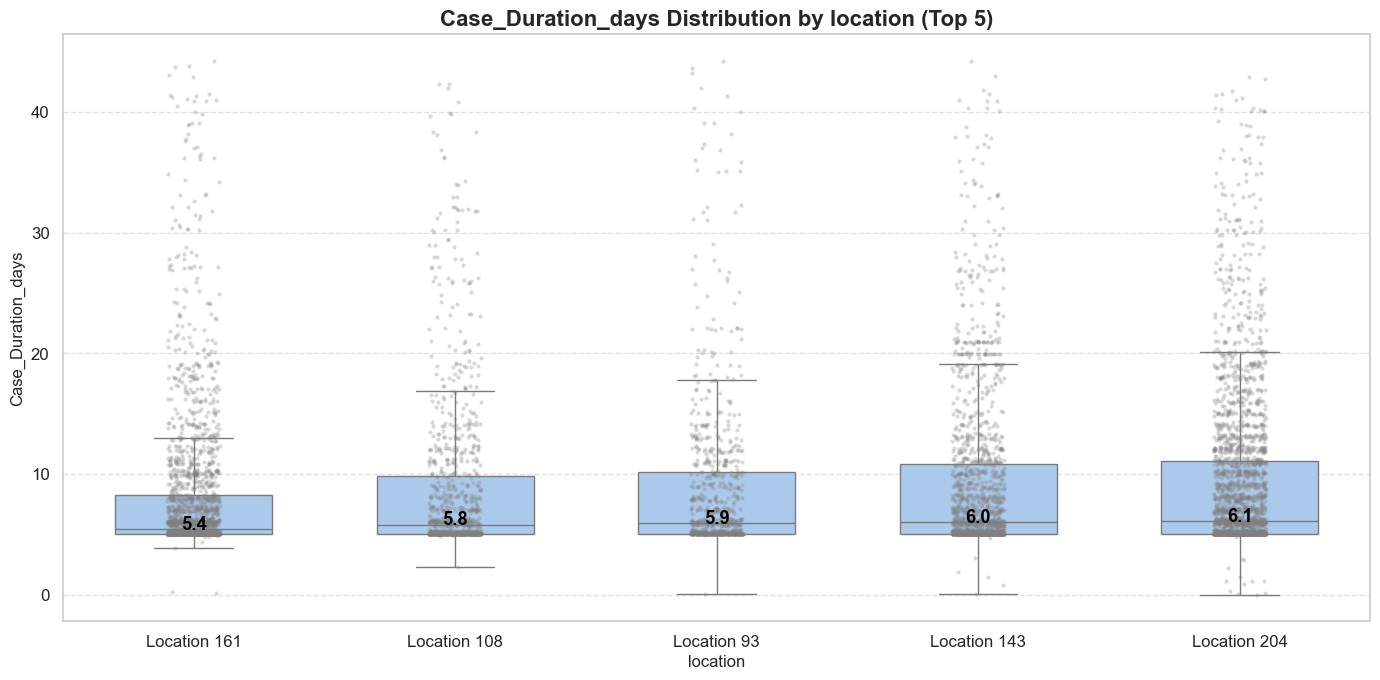

       location  Median Case_Duration_days      Mean  Count
0  Location 161                   5.420833  8.220127   2132
1  Location 108                   5.773264  8.906723   1036
2   Location 93                   5.917361  8.901751    837
3  Location 143                   5.998611  9.265662   1645
4  Location 204                   6.069792  9.299999   2652
_______________________________
F-statistic: 9.2414
p-value: 0.0


In [22]:
# compare top locations by TAT and check for statistical Significance
plot_category_boxplot(filtered_case_attributes, target = 'Case_Duration_days',attribute='location', top=5)

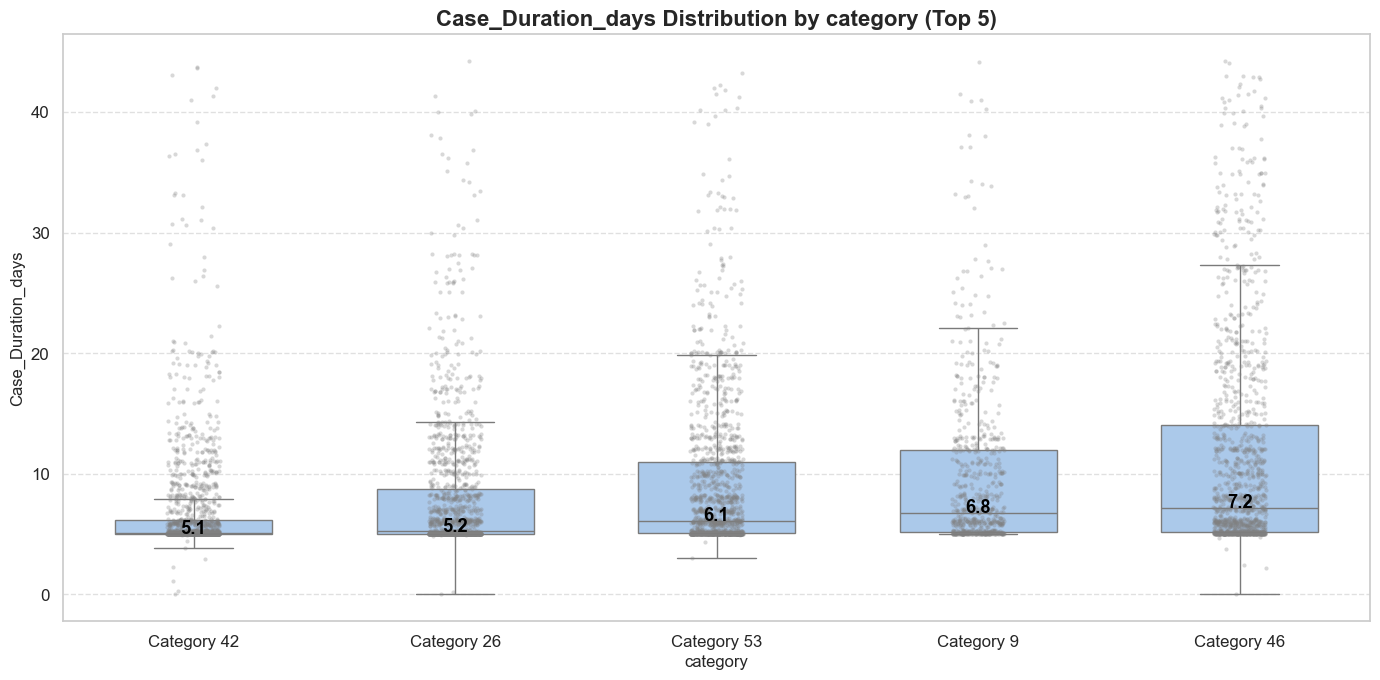

      category  Median Case_Duration_days       Mean  Count
0  Category 42                   5.083333   7.005783   1562
1  Category 26                   5.243056   8.099764   1442
2  Category 53                   6.089236   9.147581   1442
3   Category 9                   6.768750   9.623785    681
4  Category 46                   7.171181  11.385201   1308
_______________________________
F-statistic: 89.0006
p-value: 0.0


In [23]:
# compare top case categories by TAT and check for statistical Significance
plot_category_boxplot(filtered_case_attributes, target = 'Case_Duration_days',attribute='category', top=5)

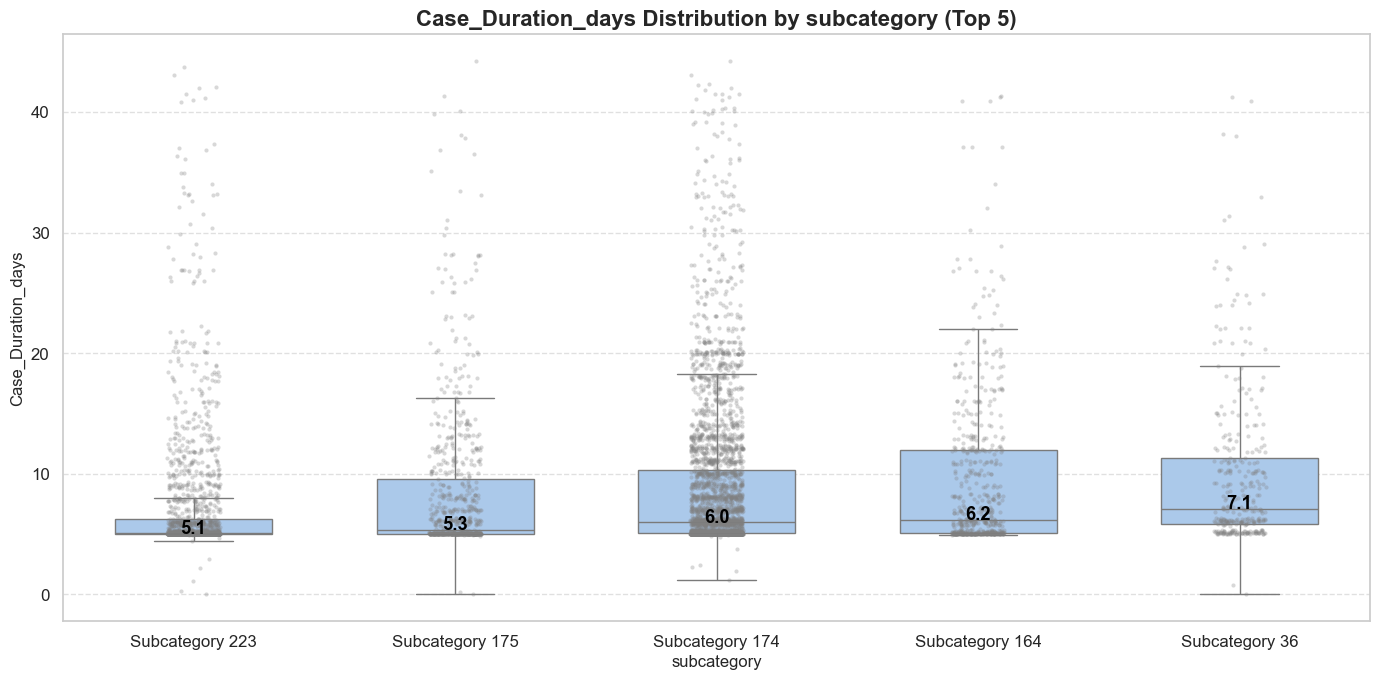

       subcategory  Median Case_Duration_days      Mean  Count
0  Subcategory 223                   5.087153  7.280640   1706
1  Subcategory 175                   5.342361  8.519342    749
2  Subcategory 174                   5.992361  9.024008   3385
3  Subcategory 164                   6.181944  9.409042    578
4   Subcategory 36                   7.100694  9.946652    341
_______________________________
F-statistic: 29.7008
p-value: 0.0


In [24]:
# compare top subcategories by TAT and check for statistical Significance
plot_category_boxplot(filtered_case_attributes, target = 'Case_Duration_days',attribute='subcategory', top=5)

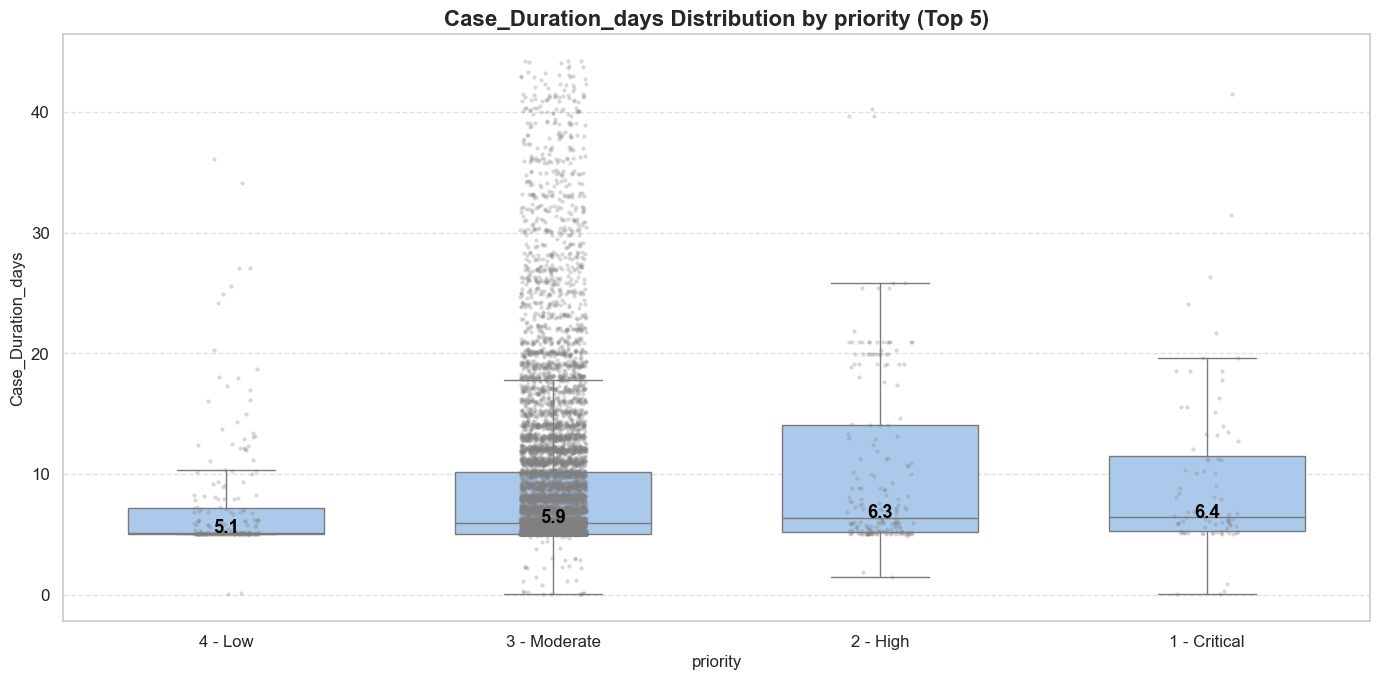

       priority  Median Case_Duration_days       Mean  Count
0       4 - Low                   5.136806   7.436732    209
1  3 - Moderate                   5.941667   8.943317  11260
2      2 - High                   6.338194  10.295368    197
3  1 - Critical                   6.392014   9.456349     84
_______________________________
F-statistic: 6.4662
p-value: 0.0002


In [25]:
# compare Priorities by TAT and check for statistical Significance
plot_category_boxplot(filtered_case_attributes, target = 'Case_Duration_days',attribute='priority', top=5)

## 3. Unsupervised Learning - Clustering

**In this section we aim to answer the forth question**  "What insights can we uncover by applying **unsupervised clustering** to the completed cases?"

To answer this question I experimented with two algorythms
1. **DBSCAN**: Although I varied the parameters, it kept considering most of the dataset as noise and producing high number of clusters
2. **K-means**: I found it useful as I can control the number of clusters and it was able to identify anomalies a few times

*Learnings: I think more research with K-means can be useful to uncover case patterens and anomalies*


In [26]:
# Filter out the features not useful for clustering
clustering_data = filtered_case_attributes.drop(['CaseID', 'opened_at', 'closed_at', 'Case_Condition', 'contact_type' ], axis=1)
clustering_data = clustering_data.fillna(0)
clustering_data = clustering_data.reset_index()


In [27]:
# Split categorical and numerical columns
categorical_cols = clustering_data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = clustering_data.select_dtypes(include=['number']).columns.tolist()

# Perform OneHot encoding on categorical data
encoded = pd.get_dummies(clustering_data[categorical_cols], drop_first=True)

# Stadardise numerical data
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(clustering_data[numerical_cols]), columns=numerical_cols)

# Combine both in a clustering ready dataframe
clustering_ready = pd.concat([scaled, encoded], axis=1)

In [28]:
dbscan = DBSCAN(eps=0.2, min_samples=5)
cluster_labels = dbscan.fit_predict(clustering_ready)

#Assess Clustering performance

# -1 means noise, exclude if too many
filtered_data = clustering_ready[cluster_labels != -1]
filtered_labels = cluster_labels[cluster_labels != -1]

if len(set(filtered_labels)) > 1:
    score = silhouette_score(filtered_data, filtered_labels)
    print(f"Silhouette Score: {score:.3f}")
else:
    print("Silhouette Score not available: less than 2 clusters.")


# Print the number of clusters 
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of clusters: {n_clusters}")

Silhouette Score: 0.970
Number of clusters: 20


In [29]:
filtered_case_attributes['cluster'] = cluster_labels

<Figure size 640x480 with 0 Axes>

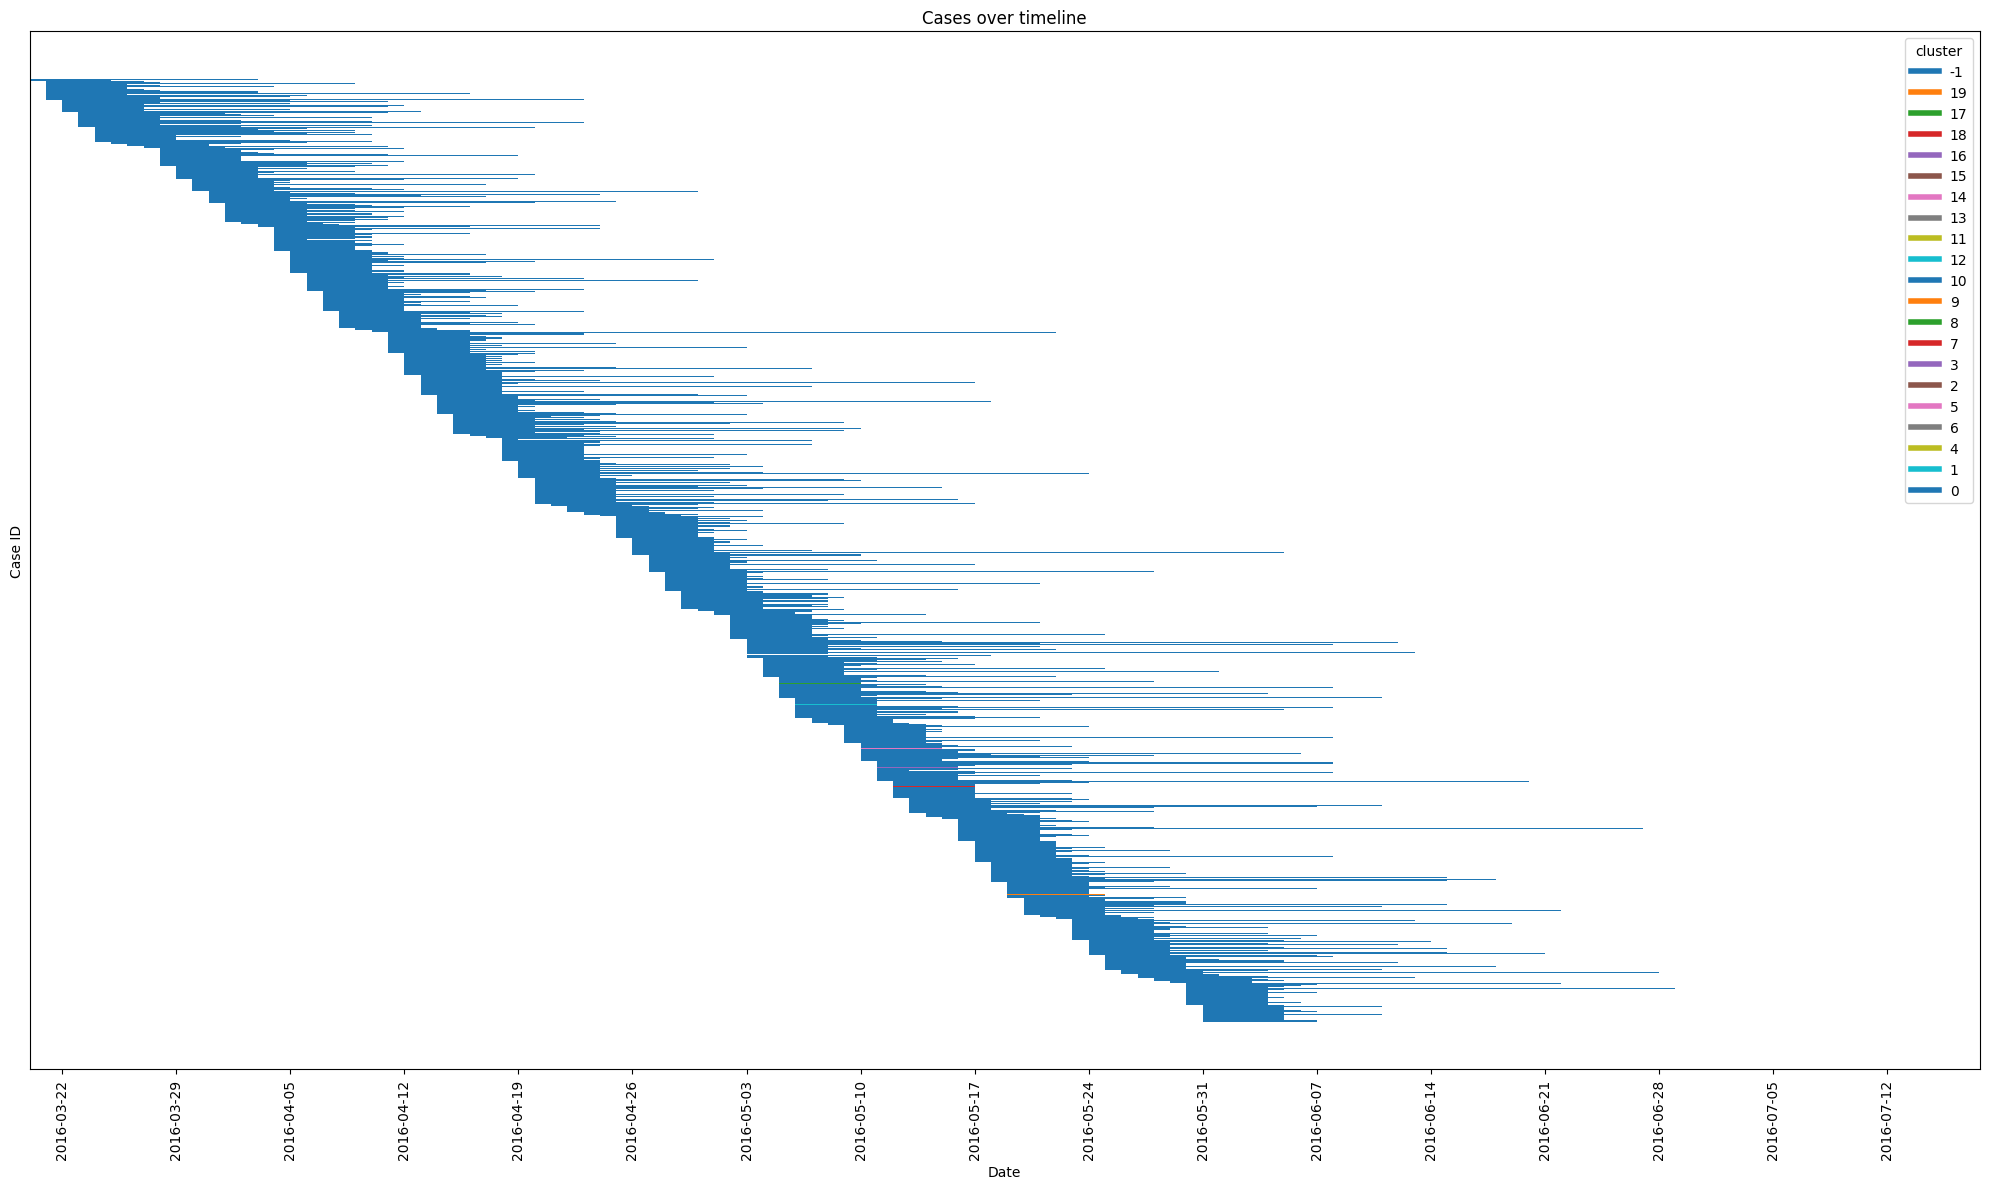

In [30]:
# plot the clusters on the case timeline to understand the composition of cases in each cluster
plot_case_timeline(filtered_case_attributes, color_by='cluster')

In [31]:
# Explore the number of clusters using KMeans and silhouette score
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=10)
    labels = kmeans.fit_predict(clustering_ready)
    score = silhouette_score(clustering_ready, labels)
    print(f"n_clusters={k}, silhouette_score={score:.3f}")

n_clusters=2, silhouette_score=0.135
n_clusters=3, silhouette_score=0.121
n_clusters=4, silhouette_score=0.124
n_clusters=5, silhouette_score=0.127
n_clusters=6, silhouette_score=0.130
n_clusters=7, silhouette_score=0.140
n_clusters=8, silhouette_score=0.144
n_clusters=9, silhouette_score=0.153
n_clusters=10, silhouette_score=0.108


In [32]:
# Fit the KMeans model with the chosen number of clusters
kmeans = KMeans(n_clusters=9, random_state=10) 
cluster_labels = kmeans.fit_predict(clustering_ready)


#Assess Clustering performance

# -1 means noise, exclude if too many
filtered_data = clustering_ready[cluster_labels != -1]
filtered_labels = cluster_labels[cluster_labels != -1]

if len(set(filtered_labels)) > 1:
    score = silhouette_score(filtered_data, filtered_labels)
    print(f"Silhouette Score: {score:.3f}")
else:
    print("Silhouette Score not available: less than 2 clusters.")


# Print the number of clusters 
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of clusters: {n_clusters}")


Silhouette Score: 0.153
Number of clusters: 9


In [33]:
# Add cluster labels to original dataframe for analysis
filtered_case_attributes['cluster'] = cluster_labels

<Figure size 640x480 with 0 Axes>

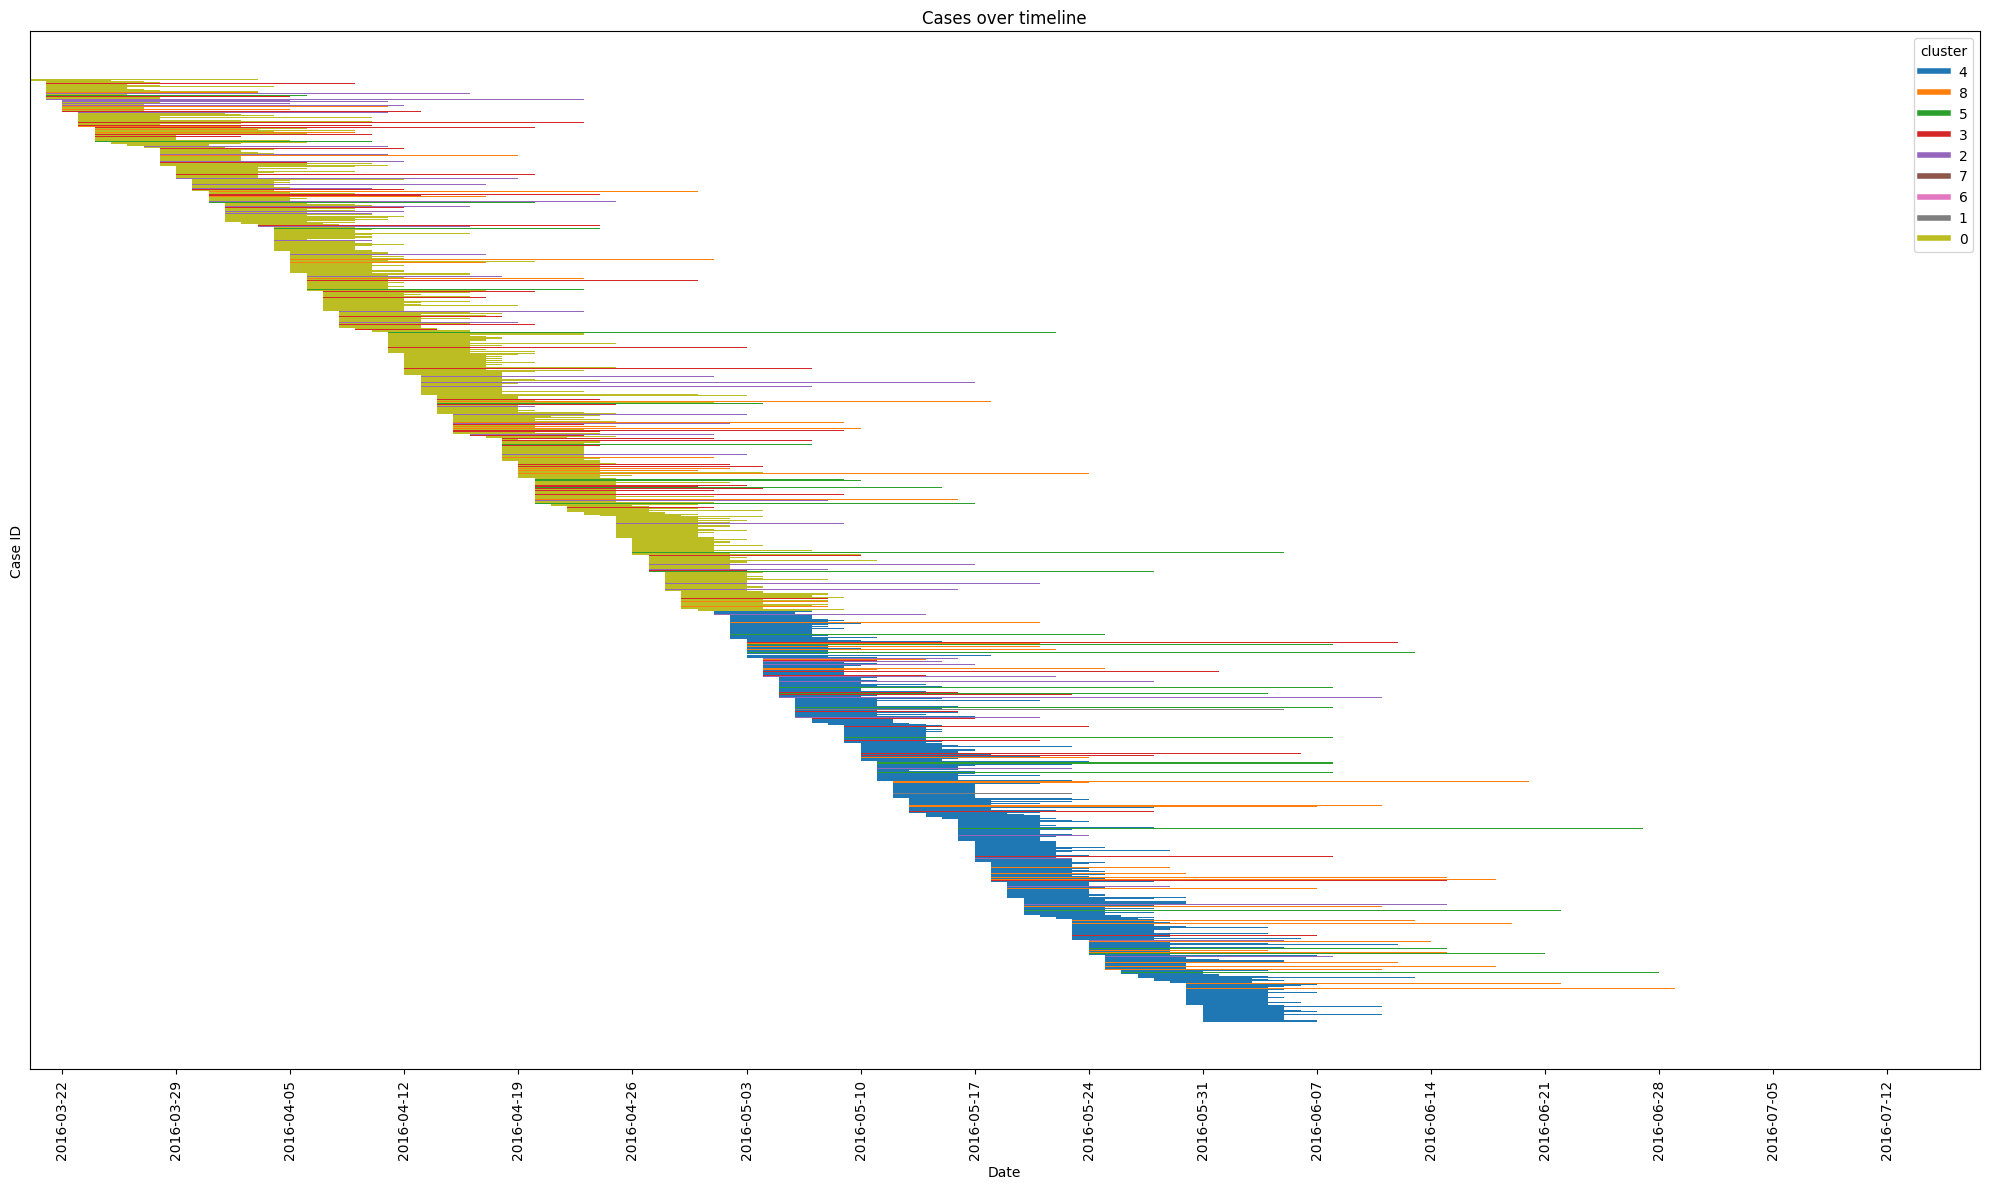

In [34]:
# plot the clusters on the case timeline to understand the composition of cases in each cluster
plot_case_timeline(filtered_case_attributes, color_by='cluster')


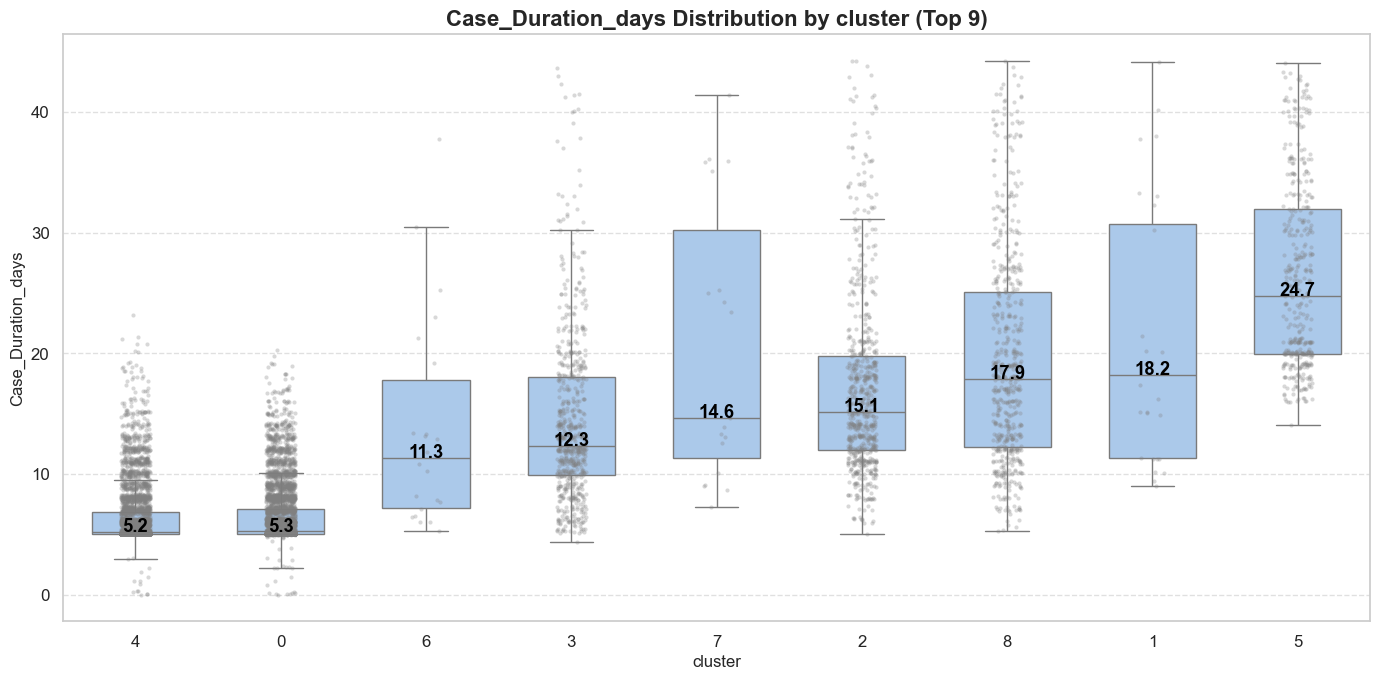

   cluster  Median Case_Duration_days       Mean  Count
0        4                   5.184028   6.434835   4261
1        0                   5.263194   6.531047   5101
2        6                  11.313889  13.796654     22
3        3                  12.343750  14.401274    649
4        7                  14.635417  20.732273     19
5        2                  15.145833  17.170910    683
6        8                  17.863194  19.472819    581
7        1                  18.232292  20.905903     28
8        5                  24.745139  26.291068    406
_______________________________
F-statistic: 2275.324
p-value: 0.0


In [35]:
#Visualise the TAT performance across clusters
plot_category_boxplot(filtered_case_attributes, target = 'Case_Duration_days',attribute='cluster', top=9)

## 4. Supervised Learning
### Aim: Predict "Time to Case Completion" based on the latest activity update

In this section we'll aim to answer our fifth question: **Can we build a model to predict the **"time remaining until case closure"**, using only the features available from the most recent status update?**

I've used three algorythms in this section:
1. **XGBoost** Best Performer, with much less overfitting than Random Forest and much quicker to train
2. **Linear Regression** Performance close to XGBoost
3. **Random Forest** The worst performer, takes a lot of time to train, and you can tell it's over fitting the training set


**This one was very challenging But I landed in a good place for further exploration and key valuable learnings:**
- Random train/test splitting is not suitable for this use case (future information will leak to the model and it will perform suspiciously good!). time-based split is the way to go
- Since the split is time based, make sure the training and test set are comming from a "Controled Process" with no anomalies - hence our filtering earlier. Otherwise, the model will learn the anomalies and perform worse that averages (i.e. Negative R2)
- Removing outliers help - need to be careful with it though
- I beleive there's more room for improvement be reviewing the predicted values vs reality and by noting the model mistakes, it can be further improved by adding more features, feature engineering, and model selection and fine tuning 
- Overall, I think the results here are encouraging and improved significantly due to all the trial and error

**Create New features** we'll add two new features to approach this problem "duration_since_case_open" , "duration_to_case_closed"

In [42]:
# To avoide the issue with writing over a copy warning
filtered_eventlog = filtered_eventlog.copy()

# Add a new feature that measures the duration since this case started
filtered_eventlog['duration_since_case_open'] =   (filtered_eventlog['EndTimeStamp'] - filtered_eventlog['opened_at']).dt.total_seconds() / (60 * 60 * 24)

# Add a new feature that measures the duration until the case is closed
filtered_eventlog['duration_to_case_closed'] =   (filtered_eventlog['closed_at'] - filtered_eventlog['EndTimeStamp']).dt.total_seconds() / (60 * 60 * 24)

**Split the dataset based on a cut-off date and balance the training/test ratio manually**

In [43]:
splitting_date = '2016-05-15'
training_ratio = len(filtered_eventlog[filtered_eventlog['EndTimeStamp'] <= splitting_date]) / len(eventlog)
training_ratio = round(training_ratio* 100, 0)
test_ratio = 100 - training_ratio

print(f"Training / Test ratio: {training_ratio}% / {test_ratio}%")

Training / Test ratio: 37.0% / 63.0%


**Select the relevant features for training**  
______
Remove :
- "CaseID": not relevant to prediction
- "opened_by": high cardinality, very little impact 
- "EndTimeStamp": high cardinality, it  might pick on certain operators causing issues and delays downstream, but will leave it our for now
- "opened_at" : not needed as it can be replaced with " duration_since_case_open"
- "closed_at" : not needed as it can be replaced with " duration_to_case_close"


Engineered features:
- "EndTimeStamp": convert to year, month, day, hour - it might pick up on any seasonality

In [44]:
prediction_eventlog = filtered_eventlog[["Activity", "active", "sys_mod_count", "EndTimeStamp", "contact_type", 
                                "location", "category", "subcategory", "priority", 
                                "duration_since_case_open", "duration_to_case_closed" ]].copy()


# Add a few more features from the end time stamp
prediction_eventlog['event_completed_year']= prediction_eventlog['EndTimeStamp'].dt.year
prediction_eventlog['event_completed_month']= prediction_eventlog['EndTimeStamp'].dt.month
prediction_eventlog['event_completed_day']= prediction_eventlog['EndTimeStamp'].dt.day
prediction_eventlog['event_completed_hour']= prediction_eventlog['EndTimeStamp'].dt.hour

# 70- 30 split the eventlog to training and testing sets based on the closed_at date
training_eventlog = prediction_eventlog[prediction_eventlog['EndTimeStamp'] <= splitting_date].copy()
testing_eventlog = prediction_eventlog[prediction_eventlog['EndTimeStamp'] > splitting_date].copy()



# Split into training and testing sets
X_train = training_eventlog.drop(columns=["duration_to_case_closed", "EndTimeStamp"])
y_train = training_eventlog["duration_to_case_closed"]
X_test = testing_eventlog.drop(columns=["duration_to_case_closed", "EndTimeStamp"])    
y_test = testing_eventlog["duration_to_case_closed"]

In [45]:
# Check if there's some balance in the target values between training and testing sets
y_train.mean(), y_train.median(), y_test.mean(),  y_test.median()

(7.302423964316963, 5.14375, 6.314778305567654, 5.038194444444445)

In [46]:
model = LinearRegression()

model_train_and_evaluate(model, X_train, y_train, X_test, y_test)

 Model name & parameters: LinearRegression()
______________________________________
No of training cases: 52574
No of testing cases: 18368

Performance Metrics:
Mean Absolute Error (MAE): 3.3138
Mean Squared Error (MSE): 26.5917
Root Mean Squared Error (RMSE): 5.1567
R² Score: 0.3210

Training Set Performance:
Mean Absolute Error (MAE): 3.3704
Mean Squared Error (MSE): 29.8250
Root Mean Squared Error (RMSE): 5.4612
R² Score: 0.3160


In [47]:
model = RandomForestRegressor(random_state=10, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, n_jobs=-1)

model_train_and_evaluate(model, X_train, y_train, X_test, y_test)

 Model name & parameters: RandomForestRegressor(n_jobs=-1, random_state=10)
______________________________________
No of training cases: 52574
No of testing cases: 18368

Performance Metrics:
Mean Absolute Error (MAE): 3.1725
Mean Squared Error (MSE): 30.6806
Root Mean Squared Error (RMSE): 5.5390
R² Score: 0.2165

Training Set Performance:
Mean Absolute Error (MAE): 0.7141
Mean Squared Error (MSE): 2.1631
Root Mean Squared Error (RMSE): 1.4707
R² Score: 0.9504


In [48]:
model = XGBRegressor(random_state=10, n_estimators=100, learning_rate=0.1, max_depth=5)

model_train_and_evaluate(model, X_train, y_train, X_test, y_test)

 Model name & parameters: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=10, ...)
______________________________________
No of training cases: 52574
No of testing cases: 18368

Performance Metrics:
Mean Absolute Error (MAE): 3.0953
Mean Squared Error (MSE): 26.2566
Root Mean Squared Error (RMSE): 5.1241
R² Score: 0